In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Lambda
%matplotlib inline

In [10]:
board_shape = (20, 20)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.15
train_size = 7000
val_size   = 1000
test_size  = 2000

Some helper functions,
some of them borrowed from = https://kylewbanks.com/blog/conways-game-of-life-convolutional-neural-network-keras
Modified to use n step, We also use a very different model architecture

In [11]:
def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    """
    Generates `num_frames` random game boards with a particular shape and a predefined 
    probability of each cell being 'alive'.
    """
    
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

# Reshape input
def reshape_input(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Dataset generator
def generate_dataset(num_frames, board_shape, prob_alive, life_step=1):
    X = generate_frames(num_frames, board_shape=board_shape, prob_alive=prob_alive)
    X = reshape_input(X)
    y = np.array([n_life_step(frame,life_step) for frame in X])
    return X, y

# Take one time-step
def life_step(X):
    """
    'Game of Life' logic, from: 
    https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/
    """
    live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (live_neighbors == 3) | (X & (live_neighbors == 2)).astype(int)

# Plot out data
def render_frames(frame1, frame2):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')
    
# Wrap-around padding for given input.
# Connect left-right and top-bottom edge
def pad_input(X):
    return reshape_input(np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for x in X
    ]))

# Generate n-step life
def n_life_step(img,life=1):
    for i in range(life):
        img=life_step(img)
    return img

# Function to check errors
def view_test_errors(model, X_test, y_test):
    y_test_pred = tf.round(model.predict_classes(X_test))
    sum_y_test_pred = np.sum(y_test_pred, axis=0).flatten().reshape(board_shape)
    sum_y_test = np.sum(y_test, axis=0).flatten().reshape(board_shape)

    plt.imshow(sum_y_test_pred - sum_y_test, cmap='hot', interpolation='nearest')
    plt.show()


Lets try to generate some test frames

Sample frame vs. next step:


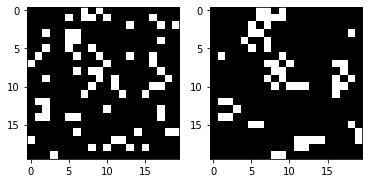

In [12]:
frames = generate_frames(20, board_shape=board_shape, prob_alive=probability_alive)
print("Sample frame vs. next step:")
render_frames(frames[1], life_step(frames[1]))

Now we will build training and test set:

In [19]:
print("Training Set:")
X_train, y_train = generate_dataset(train_size, board_shape, probability_alive,1)
print(X_train.shape)
print(y_train.shape)
print("Test Set:")
X_test, y_test =  generate_dataset(test_size, board_shape, probability_alive,1)
print(X_test.shape)
print(y_test.shape)

Training Set:
(7000, 20, 20, 1)
(7000, 20, 20, 1)
Test Set:
(2000, 20, 20, 1)
(2000, 20, 20, 1)


Lets add padding to our data sets

In [20]:
X_train_padded = pad_input(X_train).astype(np.float32)
X_test_padded = pad_input(X_test).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(X_train_padded.shape)
print(X_test_padded.shape)

(7000, 22, 22, 1)
(2000, 22, 22, 1)


New we build our model

In [21]:
modelme = Sequential()
modelme.add(Conv2D(100,3,padding='valid',activation='relu',strides=1,input_shape=(board_shape[0] + 2, board_shape[1] + 2, 1)))
modelme.add(Conv2D(1,1,activation='sigmoid'))

modelme.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelme.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 20, 100)       1000      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 1)         101       
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [30]:
modelme.fit(X_train_padded, y_train,batch_size=50,epochs=5)

Train on 7000 samples
Epoch 1/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0030 - accuracy: 0.9998s -
Epoch 2/5
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0027 - accuracy: 0.9999
Epoch 3/5
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0024 - accuracy: 0.9999
Epoch 4/5
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0022 - accuracy: 1.0000
Epoch 5/5
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0020 - accuracy: 1.0000


We need to train the model till the accuracy is 100 (we want it to overfit completely.)

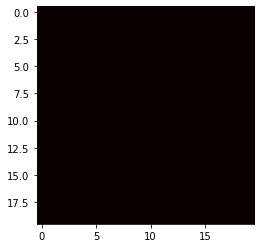

In [31]:
view_test_errors(modelme, X_test_padded, y_test)

Complete black means the model worked perfectly